In [101]:
# %pip install osfclient

In [7]:
#!osf -p hjcxg fetch osfstorage/test.mcool ./test.mcool

In [39]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-poster')

import bioframe

import cooler
import cooltools
import cooltools.expected

In [10]:
clr = cooler.Cooler('./test.mcool::/resolutions/1000')

In [23]:
hg38_chromsizes = bioframe.fetch_chromsizes('hg38', as_bed=True)
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.split(hg38_chromsizes, hg38_cens, cols_points=['chrom', 'mid'])
hg38_arms = hg38_arms[hg38_arms.chrom.isin(clr.chromnames)].reset_index(drop=True)

In [28]:
# cvd == contacts-vs-distance
cvd = cooltools.expected.diagsum(
    clr=clr,
    regions=hg38_arms,
    transforms={'balanced': lambda p: p['count']*p['weight1']*p['weight2']}
)

In [59]:
cvd_agg = (
    cvd
    .groupby('diag')
    .agg(
        {'n_valid':'sum',
         'count.sum':'sum',
         'balanced.sum':'sum',
        })
    .reset_index()
)

cvd_agg['sep'] = (
    cvd_agg['diag'] 
    * clr.binsize)
cvd_agg['count.avg'] = (
    cvd_agg['count.sum']
    / cvd_agg['n_valid']
)
cvd_agg['balanced.avg'] = (
    cvd_agg['balanced.sum']
    / cvd_agg['n_valid']
)

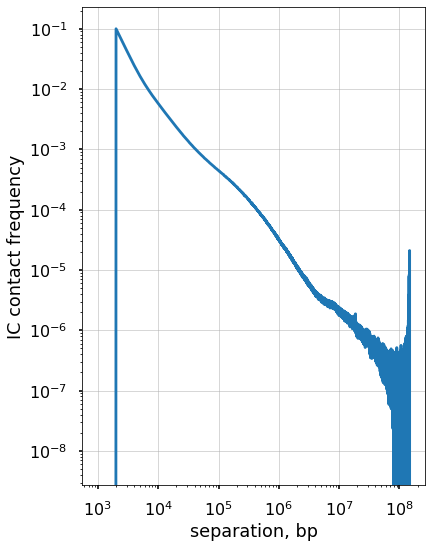

In [66]:
f, ax = plt.subplots(1,1)
ax.loglog(
    cvd_agg['sep'],
    cvd_agg['balanced.avg'],
)
ax.set(
    xlabel='separation, bp', 
    ylabel='IC contact frequency')
ax.set_aspect(1.0)
ax.grid(lw=0.5)

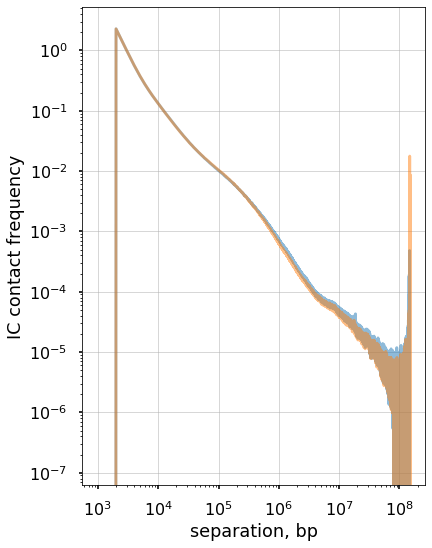

In [69]:
f, ax = plt.subplots(1,1)
ax.loglog(
    cvd_agg['sep'],
    cvd_agg['balanced.avg'] /cvd_agg['balanced.avg'].iloc[3],
    alpha=0.5
)
ax.loglog(
    cvd_agg['sep'],
    cvd_agg['count.avg'] /cvd_agg['count.avg'].iloc[3],
    alpha=0.5
)

ax.set(
    xlabel='separation, bp', 
    ylabel='IC contact frequency')
ax.set_aspect(1.0)
ax.grid(lw=0.5)

In [74]:
lbcvd, slopes, distbins = cooltools.expected.logbin_expected(cvd)
cfs_agg, slopes_agg = cooltools.expected.combine_binned_expected(
    lbcvd,
    binned_exp_slope=slopes
)
cfs_agg['sep'] = cfs_agg['x'] * clr.binsize 
slopes_agg['sep'] = slopes_agg['x'] * clr.binsize 

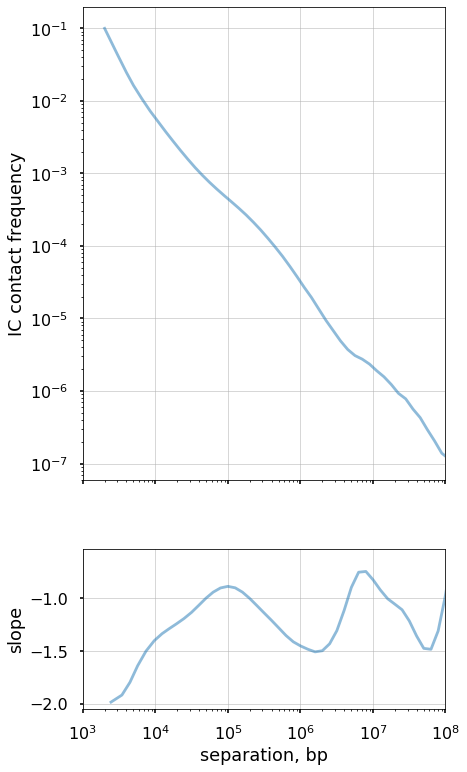

In [100]:
f, axs = plt.subplots(
    figsize=(6.5,13),
    nrows=2, 
    gridspec_kw={'height_ratios':[6,2]}, 
    sharex=True)
ax = axs[0]
ax.loglog(
    cfs_agg['sep'],
    cfs_agg['Pc'],
    alpha=0.5
)

ax.set(
#     xlabel='separation, bp', 
    ylabel='IC contact frequency',
    xlim=(1e3,1e8)
)
ax.set_aspect(1.0)
ax.grid(lw=0.5)


ax = axs[1]
ax.semilogx(
    slopes_agg['sep'],
    slopes_agg['slope'],
    alpha=0.5
)

ax.set(
    xlabel='separation, bp', 
    ylabel='slope')

ax.grid(lw=0.5)


